# 과제를 진행하기 전 필요한 함수들

In [92]:
import pandas as pd
import torch

def prepare_cryptocurrency_data(file_path, sequence_size=21, validation_size=150, test_size=30, is_regression=True):
    """
    Cryptocurrency 데이터 준비 함수.
    
    Args:
        file_path (str): 데이터 파일 경로 (CSV 형식).
        sequence_size (int): 시퀀스 크기.
        validation_size (int): 검증 데이터 크기.
        test_size (int): 테스트 데이터 크기.
        is_regression (bool): 회귀 분석 여부. True면 회귀, False면 분류.

    Returns:
        tuple: (X_train, X_val, X_test, y_train, y_val, y_test)
    """
    # 데이터 로드
    df = pd.read_csv(file_path)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]  # 필요한 열만 선택

    # 데이터 정규화
    scaler = df.max()  # 열 별 최대값으로 정규화
    df = df / scaler

    # 시퀀스 데이터 생성
    sequences, labels = [], []
    for idx in range(len(df) - sequence_size):
        seq = df.iloc[idx:idx + sequence_size].values
        label = df.iloc[idx + sequence_size]['Close']
        if not is_regression:
            # 분류인 경우: 다음 날의 Close 값이 이전 날보다 크면 1, 아니면 0
            label = 1 if label > df.iloc[idx + sequence_size - 1]['Close'] else 0
        sequences.append(seq)
        labels.append(label)

    # numpy 배열로 변환
    sequences = torch.tensor(sequences, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32 if is_regression else torch.int64)

    # 데이터 분리
    train_size = len(sequences) - validation_size - test_size
    X_train, y_train = sequences[:train_size], labels[:train_size]
    X_val, y_val = sequences[train_size:train_size + validation_size], labels[train_size:train_size + validation_size]
    X_test, y_test = sequences[train_size + validation_size:], labels[train_size + validation_size:]

    return X_train, X_val, X_test, y_train, y_val, y_test

# 테스트
if __name__ == "__main__":
    # 파일 경로 설정
    file_path = "./BTC_KRW.csv"

    # Regression 데이터 준비
    print("Preparing regression data...")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_cryptocurrency_data(
        file_path, sequence_size=21, validation_size=150, test_size=30, is_regression=True
    )
    print(f"Regression: Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

    # Classification 데이터 준비
    print("\nPreparing classification data...")
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_cryptocurrency_data(
        file_path, sequence_size=21, validation_size=150, test_size=30, is_regression=False
    )
    print(f"Classification: Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Preparing regression data...
Regression: Train shape: torch.Size([3527, 21, 5]), Validation shape: torch.Size([150, 21, 5]), Test shape: torch.Size([30, 21, 5])

Preparing classification data...
Classification: Train shape: torch.Size([3527, 21, 5]), Validation shape: torch.Size([150, 21, 5]), Test shape: torch.Size([30, 21, 5])


In [93]:
#15f-argparser

In [94]:
import argparse


def get_parser():
    parser = argparse.ArgumentParser()

    parser.add_argument(
    "--wandb", action=argparse.BooleanOptionalAction, default=False, help="True or False"
    )

    parser.add_argument(
    "-b", "--batch_size", type=int, default=2048, help="Batch size (int, default: 2_048)"
    )

    parser.add_argument(
    "-e", "--epochs", type=int, default=10_000, help="Number of training epochs (int, default:10_000)"
    )

    parser.add_argument(
    "-r", "--learning_rate", type=float, default=1e-4, help="Learning rate (float, default: 1e-3)"
    )

    parser.add_argument(
    "-w", "--weight_decay", type=float, default=0.0, help="Weight decay (float, default: 0.0)"
    )

    parser.add_argument(
    "-v", "--validation_intervals", type=int, default=30,
    help="Number of training epochs between validations (int, default: 10)"
    )

    parser.add_argument(
    "-p", "--early_stop_patience", type=int, default=30,
    help="Number of early stop patience (int, default: 10)"
    )

    parser.add_argument(
    "-d", "--early_stop_delta", type=float, default=0.000001,
    help="Delta value of early stop (float, default: 0.000001)"
    )

    return parser


In [95]:
#8c-earlystopping

In [96]:
import os
import torch


class EarlyStopping:
    """Validation Loss가 개선되지 않으면 학습을 조기에 중단하는 클래스."""
    def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
        """
        초기화 메서드.
        Args:
            patience (int): 개선되지 않을 때 기다릴 에폭 수.
            delta (float): Loss 감소 최소값.
            project_name (str): 프로젝트 이름 (체크포인트 파일명에 사용).
            checkpoint_file_path (str): 체크포인트 저장 경로.
            run_time_str (str): 체크포인트 파일명에 사용할 고유 문자열.
        """
        self.patience = patience  # 개선되지 않을 때 기다릴 최대 에폭 수
        self.counter = 0  # 개선되지 않은 에폭 수를 추적
        self.delta = delta  # 개선으로 간주되는 최소 Loss 감소값
        self.val_loss_min = None  # 현재까지의 최소 Validation Loss 저장
        self.file_path = os.path.join(
            checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
        )  # 체크포인트 저장 경로
        self.latest_file_path = os.path.join(
            checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
        )  # 최신 체크포인트 저장 경로

    def check_and_save(self, new_validation_loss, model):
        """
        Validation Loss를 확인하고 필요 시 모델 저장.
        Args:
            new_validation_loss (float): 현재 에폭의 Validation Loss.
            model (torch.nn.Module): 저장할 PyTorch 모델.
        Returns:
            message (str): 현재 상태 메시지.
            early_stop (bool): 조기 종료 여부.
        """
        early_stop = False

        if self.val_loss_min is None:
            # 최초 Validation Loss 설정
            self.val_loss_min = new_validation_loss
            message = f'Early stopping is stated!'
        elif new_validation_loss < self.val_loss_min - self.delta:
            # Validation Loss가 개선된 경우
            message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
            self.save_checkpoint(new_validation_loss, model)
            self.val_loss_min = new_validation_loss  # 최소 Loss 업데이트
            self.counter = 0  # Counter 초기화
        else:
            # 개선되지 않은 경우 Counter 증가
            self.counter += 1
            message = f'Early stopping counter: {self.counter} out of {self.patience}'
            if self.counter >= self.patience:
                early_stop = True  # Patience 초과 시 조기 종료
                message += " *** TRAIN EARLY STOPPED! ***"

        return message, early_stop

    def save_checkpoint(self, val_loss, model):
        """
        Validation Loss 개선 시 모델 저장.
        Args:
            val_loss (float): 현재 Validation Loss.
            model (torch.nn.Module): 저장할 PyTorch 모델.
        """
        torch.save(model.state_dict(), self.file_path)  # 지정된 파일명으로 모델 저장
        torch.save(model.state_dict(), self.latest_file_path)  # 최신 파일명으로 모델 저장
        print(f"Model checkpoint saved at: {os.path.join(CHECKPOINT_FILE_PATH, 'lstm_regression_btc_krw_checkpoint_latest.pt')}")
        self.val_loss_min = val_loss  # 최소 Loss 업데이트

In [97]:
#99common-strfdelta

In [98]:
import os
import sys
import string
from string import Template 

# 운영체제 확인 함수
def is_linux():
    return sys.platform.startswith("linux")

def is_windows():
    return os.name == "nt"

def is_mac():
    return sys.platform == "darwin"

# CPU 코어 수 확인 함수
def get_num_cpu_cores():
    import multiprocessing
    return multiprocessing.cpu_count()

# timedelta 형식 변환 클래스 및 함수
class DeltaTemplate(Template):
    delimiter = "%"

def strfdelta(td, fmt):
    sign = "-" if td.days < 0 else "+"  # 음수일 경우 '-' 추가
    secs = abs(td).total_seconds()  # 절대값으로 초 계산
    days, rem = divmod(secs, 86400)  # 초를 일, 시간, 분으로 분리
    hours, rem = divmod(rem, 3600)
    mins, secs = divmod(rem, 60)
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
    )

def strfdelta(td, fmt):

    # Get the timedelta’s sign and absolute number of seconds.
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()

    # Break the seconds into more readable quantities.
    days, rem = divmod(secs, 86400)  # Seconds per day: 24 * 60 * 60
    hours, rem = divmod(rem, 3600)  # Seconds per hour: 60 * 60
    mins, secs = divmod(rem, 60)

    # Format (as per above answers) and return the result string.
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
        )


if __name__ == "__main__":
    if is_linux():
        print("Linux")
    elif is_windows():
        print("Windows")
    elif is_mac():
        print("Mac")
    else:
        print("<unknown>")


Linux


In [99]:
#14g-rnntrainer

In [100]:
from datetime import datetime
import torch
from torch import nn

# RegressionTrainer 클래스
class RegressionTrainer:
    def __init__(
        self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
        run_time_str, wandb, device, checkpoint_file_path
    ):
        self.project_name = project_name
        self.model = model
        self.optimizer = optimizer
        self.train_data_loader = train_data_loader
        self.validation_data_loader = validation_data_loader
        self.transforms = transforms
        self.run_time_str = run_time_str
        self.wandb = wandb
        self.device = device
        self.checkpoint_file_path = checkpoint_file_path

        # Use a built-in loss function
        self.loss_fn = nn.MSELoss()

    def do_train(self):
        self.model.train()  # Set the model to training mode

        loss_train = 0.0
        num_trains = 0

        for train_batch in self.train_data_loader:
            input_train, target_train = train_batch
            input_train = input_train.to(device=self.device)
            target_train = target_train.to(device=self.device)

            if self.transforms:
                input_train = self.transforms(input_train)

            output_train = self.model(input_train)

            loss = self.loss_fn(output_train.squeeze(dim=-1), target_train)

            loss_train += loss.item()
            num_trains += 1

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        train_loss = loss_train / num_trains
        return train_loss

    def do_validation(self):
        self.model.eval()  # Set the model to evaluation mode

        loss_validation = 0.0
        num_validations = 0

        with torch.no_grad():
            for validation_batch in self.validation_data_loader:
                input_validation, target_validation = validation_batch
                input_validation = input_validation.to(device=self.device)
                target_validation = target_validation.to(device=self.device)

                if self.transforms:
                    input_validation = self.transforms(input_validation)

                output_validation = self.model(input_validation)

                loss_validation += self.loss_fn(output_validation.squeeze(dim=-1), target_validation).item()
                num_validations += 1

        validation_loss = loss_validation / num_validations
        return validation_loss

    def train_loop(self):
        early_stopping = EarlyStopping(
            patience=self.wandb.config.early_stop_patience,
            delta=self.wandb.config.early_stop_delta,
            project_name=self.project_name,
            checkpoint_file_path=self.checkpoint_file_path,
            run_time_str=self.run_time_str
        )
        n_epochs = self.wandb.config.epochs
        training_start_time = datetime.now()

        for epoch in range(1, n_epochs + 1):
            train_loss = self.do_train()

            if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
                validation_loss = self.do_validation()

                elapsed_time = datetime.now() - training_start_time
                epoch_per_second = 1000 * epoch / elapsed_time.microseconds

                message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

                print(
                    f"[Epoch {epoch:>3}] "
                    f"T_loss: {train_loss:7.5f}, "
                    f"V_loss: {validation_loss:7.5f}, "
                    f"{message} | "
                    f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
                    f"T_speed: {epoch_per_second:4.3f}"
                )

                self.wandb.log({
                    "Epoch": epoch,
                    "Training loss": train_loss,
                    "Validation loss": validation_loss,
                    "Training speed (epochs/sec.)": epoch_per_second,
                })

                if early_stop:
                    break

        elapsed_time = datetime.now() - training_start_time
        print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


In [101]:
#14p

In [102]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import os
import torch
import pandas as pd
import numpy as np

# BASE_PATH 수정: 현재 디렉토리를 기준으로 설정
BASE_PATH = str(Path(os.getcwd()))  # Jupyter Notebook에서 동작하도록 수정
import sys
sys.path.append(BASE_PATH)

# CryptoCurrencyDataset 클래스
class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y, is_regression=True):
        self.X = X
        self.y = y

        assert len(self.X) == len(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return X, y

    def __str__(self):
        return "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
            len(self.X), self.X.shape, self.y.shape
        )

# 데이터 로드 및 정규화 함수
def get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
    btc_krw_path = "./BTC_KRW.csv"
    df = pd.read_csv(btc_krw_path)
    row_size = len(df)
    # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    date_list = df['Date']

    df = df.drop(columns=['Date'])

    data_size = row_size - sequence_size
    # Train, Validation, Test 데이터 분리
    train_size = data_size - (validation_size + test_size)

    row_cursor = 0

    # Train data
    X_train_list = []
    y_train_regression_list = []
    y_train_classification_list = []
    y_train_date = []
    for idx in range(0, train_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_train_list.append(torch.from_numpy(sequence_data))
        y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_train_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_train_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_train = torch.stack(X_train_list, dim=0).to(torch.float)
    y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
    y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

    m = X_train.mean(dim=0, keepdim=True)
    s = X_train.std(dim=0, keepdim=True)
    X_train = (X_train - m) / s

    # Validation data
    X_validation_list = []
    y_validation_regression_list = []
    y_validation_classification_list = []
    y_validation_date = []
    for idx in range(row_cursor, row_cursor + validation_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_validation_list.append(torch.from_numpy(sequence_data))
        y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_validation_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_validation_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
    y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
    y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

    X_validation = (X_validation - m) / s

    # Test data
    X_test_list = []
    y_test_regression_list = []
    y_test_classification_list = []
    y_test_date = []
    for idx in range(row_cursor, row_cursor + test_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values
        X_test_list.append(torch.from_numpy(sequence_data))
        y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_test_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_test_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_test = torch.stack(X_test_list, dim=0).to(torch.float)
    y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
    y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

    X_test = (X_test - m) / s

    if is_regression:
        return (
            X_train, X_validation, X_test,
            y_train_regression, y_validation_regression, y_test_regression,
            y_train_date, y_validation_date, y_test_date
        )
    else:
        return (
            X_train, X_validation, X_test,
            y_train_classification, y_validation_classification, y_test_classification,
            y_train_date, y_validation_date, y_test_date
        )


if __name__ == "__main__":
    is_regression = False

    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
        sequence_size=10, validation_size=100, test_size=10,
        target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
    )

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True
    )

    for idx, batch in enumerate(train_data_loader):
        input, target = batch
        print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))


0 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1])
1 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0])
2 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 0])
3 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0])
4 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 0])
5 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 0])
6 - torch.Size([32, 10, 5]): torch.Size(

In [103]:
#08c-trainer

In [104]:
from datetime import datetime
import torch
from torch import nn

# ClassificationTrainer 클래스
class ClassificationTrainer:
    def __init__(
        self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
        run_time_str, wandb, device, checkpoint_file_path
    ):
        self.project_name = project_name
        self.model = model
        self.optimizer = optimizer
        self.train_data_loader = train_data_loader
        self.validation_data_loader = validation_data_loader
        self.transforms = transforms
        self.run_time_str = run_time_str
        self.wandb = wandb
        self.device = device
        self.checkpoint_file_path = checkpoint_file_path

        # 분류 모델의 손실 함수
        self.loss_fn = nn.CrossEntropyLoss()

    # 학습 단계
    def do_train(self):
        self.model.train()

        loss_train = 0.0
        num_corrects_train = 0
        num_trained_samples = 0
        num_trains = 0

        for train_batch in self.train_data_loader:
            input_train, target_train = train_batch
            input_train = input_train.to(device=self.device)
            target_train = target_train.to(device=self.device)

            if self.transforms:
                input_train = self.transforms(input_train)

            output_train = self.model(input_train)
            loss = self.loss_fn(output_train, target_train)
            loss_train += loss.item()

            # 정확도 계산
            predicted_train = torch.argmax(output_train, dim=-1)
            num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()
            num_trained_samples += len(input_train)
            num_trains += 1

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        train_loss = loss_train / num_trains
        train_accuracy = 100.0 * num_corrects_train / num_trained_samples

        return train_loss, train_accuracy

    # 검증 단계
    def do_validation(self):
        self.model.eval()

        loss_validation = 0.0
        num_corrects_validation = 0
        num_validated_samples = 0
        num_validations = 0

        with torch.no_grad():
            for validation_batch in self.validation_data_loader:
                input_validation, target_validation = validation_batch
                input_validation = input_validation.to(device=self.device)
                target_validation = target_validation.to(device=self.device)

                if self.transforms:
                    input_validation = self.transforms(input_validation)

                output_validation = self.model(input_validation)
                loss_validation += self.loss_fn(output_validation, target_validation).item()

                # 정확도 계산
                predicted_validation = torch.argmax(output_validation, dim=1)
                num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()
                num_validated_samples += len(input_validation)
                num_validations += 1

        validation_loss = loss_validation / num_validations
        validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

        return validation_loss, validation_accuracy

    # 학습 루프
    def train_loop(self):
        early_stopping = EarlyStopping(
            patience=self.wandb.config.early_stop_patience,
            delta=self.wandb.config.early_stop_delta,
            project_name=self.project_name,
            checkpoint_file_path=self.checkpoint_file_path,
            run_time_str=self.run_time_str
        )
        n_epochs = self.wandb.config.epochs
        training_start_time = datetime.now()

        for epoch in range(1, n_epochs + 1):
            train_loss, train_accuracy = self.do_train()

            if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
                validation_loss, validation_accuracy = self.do_validation()

                elapsed_time = datetime.now() - training_start_time
                epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

                message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

                print(
                    f"[Epoch {epoch:>3}] "
                    f"T_loss: {train_loss:7.5f}, "
                    f"T_accuracy: {train_accuracy:6.4f} | "
                    f"V_loss: {validation_loss:7.5f}, "
                    f"V_accuracy: {validation_accuracy:6.4f} | "
                    f"{message} | "
                    f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
                    f"T_speed: {epoch_per_second:4.3f}"
                )

                # wandb 로그 저장
                self.wandb.log({
                    "Epoch": epoch,
                    "Training loss": train_loss,
                    "Training accuracy (%)": train_accuracy,
                    "Validation loss": validation_loss,
                    "Validation accuracy (%)": validation_accuracy,
                    "Training speed (epochs/sec.)": epoch_per_second,
                })

                if early_stop:
                    break

        elapsed_time = datetime.now() - training_start_time
        print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


# 과제1

In [192]:
#15-g_crypto_currency_regression_train_lstm

In [106]:
!pip install wandb
import wandb

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [107]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = os.getcwd()  # 현재 작업 디렉터리를 BASE_PATH로 설정
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

# BTC-KRW 데이터 로드 및 DataLoader 생성
def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, is_regression=True):
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = get_cryptocurrency_data(
        sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
        target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
    )

    # Dataset 및 DataLoader 생성
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    validation_data_loader = DataLoader(
        dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
    )
    test_data_loader = DataLoader(
        dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
    )

    return train_data_loader, validation_data_loader, test_data_loader

# LSTM 기반 모델 정의
def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True)
            self.fcn = nn.Linear(in_features=128, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :] # 마지막 타임스텝의 출력만 사용
            x = self.fcn(x)
            return x

    return MyModel(n_input=5, n_output=1)

# 메인 함수
def main():
    # 기본 설정 값
    class Args:
        wandb = True
        batch_size = 32
        epochs = 10_000  
        learning_rate = 1e-4  
        validation_intervals = 10  
        early_stop_patience = 10 
        early_stop_delta = 0.00001
        weight_decay = 0.01

    args = Args()

    # 실행 시간 문자열 생성
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # Config 설정
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay,
    }

    # Wandb 초기화
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project="btc-krw-15g",
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config,
    )
    
    if 'early_stop_patience' not in wandb.config:
        wandb.config.update({'early_stop_patience': args.early_stop_patience})
        
    if 'validation_intervals' not in wandb.config:
        wandb.config.update({'validation_intervals': 10})  # 기본값 10 설정
    
    if 'early_stop_delta' not in wandb.config:
        wandb.config.update({'early_stop_delta': args.early_stop_delta})
        
    if 'weight_decay' not in wandb.config:
        print("Setting default weight_decay in wandb.config.")
        wandb.config.update({'weight_decay': args.weight_decay})

    print("Updated Wandb Config Contents:", dict(wandb.config))  # 업데이트된 Config 

    train_data_loader, validation_data_loader, _ = get_btc_krw_data()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model()
    model.to(device)

    # 옵티마이저 설정
    optimizer = optim.Adam(
        model.parameters(),
        lr=wandb.config.learning_rate,
        weight_decay=wandb.config.weight_decay
    )

    # RegressionTrainer 초기화 및 학습 루프 시작
    regression_trainer = RegressionTrainer(
        "btc-krw", model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    regression_trainer.train_loop()

    # Wandb 종료
    wandb.finish()


if __name__ == "__main__":
    main()

    # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

Updated Wandb Config Contents: {'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.01}
Training on device cuda:0.
[Epoch   1] T_loss: 10.67027, V_loss: 81.20151, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.024
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch  30] T_loss: 7.88762, V_loss: 60.42817, V_loss decreased (81.20151 --> 60.42817). Saving model... | T_time: 00:00:01, T_speed: 0.099
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch  60] T_loss: 0.83223, V_loss: 12.54450, V_loss decreased (60.42817 --> 12.54450). Saving model... | T_time: 00:00:02, T_speed: 0.106
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch  90] T_loss: 0.43614, V_loss: 8.79695, V_loss decreased (12.54450 --> 8.79695). Saving model..

Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch 1050] T_loss: 0.04384, V_loss: 1.09963, V_loss decreased (1.11532 --> 1.09963). Saving model... | T_time: 00:00:45, T_speed: 20.031
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch 1080] T_loss: 0.04333, V_loss: 1.09125, V_loss decreased (1.09963 --> 1.09125). Saving model... | T_time: 00:00:46, T_speed: 2.282
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch 1110] T_loss: 0.04277, V_loss: 1.07084, V_loss decreased (1.09125 --> 1.07084). Saving model... | T_time: 00:00:47, T_speed: 1.534
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch 1140] T_loss: 0.04207, V_loss: 1.05623, V_loss decreased (1.07084 --> 1.05623). Saving model... | T_time: 00:00:48, T_speed: 1.145
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_b

[Epoch 2220] T_loss: 0.03461, V_loss: 0.79805, Early stopping counter: 2 out of 30 | T_time: 00:01:35, T_speed: 17.804
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch 2250] T_loss: 0.03434, V_loss: 0.78005, V_loss decreased (0.79002 --> 0.78005). Saving model... | T_time: 00:01:36, T_speed: 5.897
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch 2280] T_loss: 0.03454, V_loss: 0.76843, V_loss decreased (0.78005 --> 0.76843). Saving model... | T_time: 00:01:37, T_speed: 2.806
[Epoch 2310] T_loss: 0.03459, V_loss: 0.77807, Early stopping counter: 1 out of 30 | T_time: 00:01:39, T_speed: 31.269
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch 2340] T_loss: 0.03445, V_loss: 0.76525, V_loss decreased (0.76843 --> 0.76525). Saving model... | T_time: 00:01:40, T_speed: 7.197
Model checkpoint saved at: /home/work/checkpoints/lstm_regressi

[Epoch 3600] T_loss: 0.03176, V_loss: 0.60620, Early stopping counter: 3 out of 30 | T_time: 00:02:34, T_speed: 8.590
[Epoch 3630] T_loss: 0.03177, V_loss: 0.59980, Early stopping counter: 4 out of 30 | T_time: 00:02:35, T_speed: 4.196
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch 3660] T_loss: 0.03132, V_loss: 0.59103, V_loss decreased (0.59825 --> 0.59103). Saving model... | T_time: 00:02:37, T_speed: 25.961
[Epoch 3690] T_loss: 0.03170, V_loss: 0.60372, Early stopping counter: 1 out of 30 | T_time: 00:02:38, T_speed: 8.987
[Epoch 3720] T_loss: 0.03148, V_loss: 0.60680, Early stopping counter: 2 out of 30 | T_time: 00:02:39, T_speed: 5.296
[Epoch 3750] T_loss: 0.03158, V_loss: 0.60503, Early stopping counter: 3 out of 30 | T_time: 00:02:40, T_speed: 3.884
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch 3780] T_loss: 0.03140, V_loss: 0.57815, V_loss decreased (0.59103 --> 0.57

[Epoch 5430] T_loss: 0.03119, V_loss: 0.52730, Early stopping counter: 1 out of 30 | T_time: 00:03:53, T_speed: 21.220
[Epoch 5460] T_loss: 0.03048, V_loss: 0.52910, Early stopping counter: 2 out of 30 | T_time: 00:03:54, T_speed: 10.146
[Epoch 5490] T_loss: 0.03104, V_loss: 0.52249, Early stopping counter: 3 out of 30 | T_time: 00:03:55, T_speed: 6.989
[Epoch 5520] T_loss: 0.03088, V_loss: 0.52478, Early stopping counter: 4 out of 30 | T_time: 00:03:57, T_speed: 187.024
[Epoch 5550] T_loss: 0.03127, V_loss: 0.53259, Early stopping counter: 5 out of 30 | T_time: 00:03:58, T_speed: 20.363
[Epoch 5580] T_loss: 0.03097, V_loss: 0.55186, Early stopping counter: 6 out of 30 | T_time: 00:03:59, T_speed: 8.013
[Epoch 5610] T_loss: 0.03069, V_loss: 0.54662, Early stopping counter: 7 out of 30 | T_time: 00:04:00, T_speed: 5.930
[Epoch 5640] T_loss: 0.03086, V_loss: 0.53922, Early stopping counter: 8 out of 30 | T_time: 00:04:02, T_speed: 29.333
[Epoch 5670] T_loss: 0.03084, V_loss: 0.53997, Ear

In [193]:
#15-h_crypto_currency_regression_test_lstm

In [109]:
import os

# 경로 설정
CHECKPOINT_FILE_PATH = "/home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt"

# 파일 존재 여부 확인
if os.path.exists(CHECKPOINT_FILE_PATH):
    print(f"File exists: {CHECKPOINT_FILE_PATH}")
else:
    print(f"File does not exist: {CHECKPOINT_FILE_PATH}")

# 체크포인트 디렉토리 내 모든 파일 출력
CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_FILE_PATH)
if os.path.isdir(CHECKPOINT_DIR):
    print("Files in checkpoint directory:")
    for file in os.listdir(CHECKPOINT_DIR):
        print(file)
else:
    print(f"Checkpoint directory does not exist: {CHECKPOINT_DIR}")


File does not exist: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
Files in checkpoint directory:
btc-krw_checkpoint_2024-12-21_17-38-20.pt
btc-krw_checkpoint_2024-12-21_18-14-44.pt
btc-krw-15i_checkpoint_2024-12-21_17-50-50.pt
btc-krw_checkpoint_2024-12-21_17-23-34.pt
btc-krw-15i_checkpoint_latest.pt
btc-krw_checkpoint_2024-12-21_17-30-22.pt
btc-krw_checkpoint_2024-12-21_18-18-38.pt
btc-krw_checkpoint_latest.pt
btc-krw_checkpoint_2024-12-21_16-51-23.pt


/home/work/checkpoints/btc-krw-15g_checkpoint_latest.pt
MODEL FILE: /home/work/checkpoints/btc-krw_checkpoint_latest.pt
[TEST DATA]
 0: 1,147.97 <--> 1,334.58 (Loss:        186.61)
 1: 1,147.66 <--> 1,360.09 (Loss:        212.44)
 2: 1,120.75 <--> 1,380.87 (Loss:        260.12)
 3: 1,153.97 <--> 1,302.60 (Loss:        148.63)
 4: 1,146.41 <--> 1,331.62 (Loss:        185.20)
 5: 1,114.41 <--> 1,319.45 (Loss:        205.03)
 6: 1,139.58 <--> 1,373.29 (Loss:        233.71)
 7: 1,148.35 <--> 1,378.05 (Loss:        229.70)
 8: 1,153.43 <--> 1,284.38 (Loss:        130.95)
 9: 1,129.00 <--> 1,390.43 (Loss:        261.43)


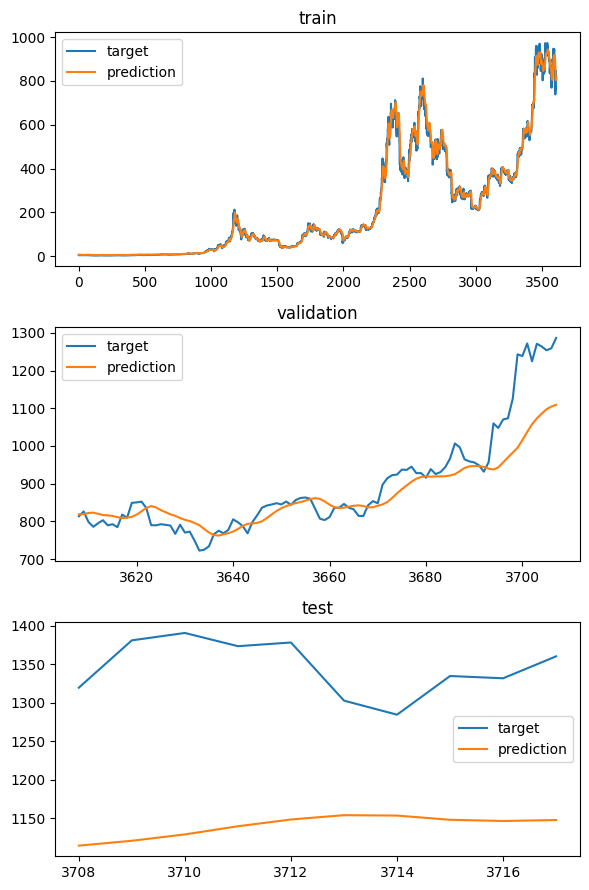

In [110]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

BASE_PATH = os.getcwd()  # 현재 작업 디렉터리를 BASE_PATH로 설정
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

# 테스트 함수
def test(test_model):
    _, _, test_data_loader = get_btc_krw_data()

    test_model.eval()

    y_normalizer = 100

    print("[TEST DATA]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            output_test = test_model(input_test)

        # 예측값과 실제값 출력
        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                idx,
                output.item() * y_normalizer,
                target.item() * y_normalizer,
                abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
            ))

# 전체 데이터셋에 대해 예측 및 시각화
def predict_all(test_model):
    y_normalizer = 100

    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
            sequence_size=10, validation_size=100, test_size=10,
            target_column='Close', y_normalizer=1.0e7, is_regression=True
    )

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    # 데이터셋 및 라벨 설정
    dataset_list = [
        train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
    ]
    dataset_labels = [
        "train", "validation", "test"
    ]
    num = 0
    
    # 시각화
    fig, axs = plt.subplots(3, 1, figsize=(6, 9))

    for i in range(3):
        X = []
        TARGET_Y = []
        PREDICTION_Y = []
        for data in dataset_list[i]:
            input, target = data
            prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

            X.append(num)
            TARGET_Y.append(target.item() * y_normalizer)
            PREDICTION_Y.append(prediction.item() * y_normalizer)

            num += 1

        axs[i].plot(X, TARGET_Y, label='target')
        axs[i].plot(X, PREDICTION_Y, label='prediction')
        axs[i].set_title(dataset_labels[i])
        axs[i].legend()

    plt.tight_layout()
    plt.show()


def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
    }

    project_name = "btc-krw-15g"
    print(os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"))
    wandb.init(
        mode="disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config
    )

    # 모델 초기화 및 체크포인트 로드
    test_model = get_model()

    project_name = "btc-krw"
    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
    )
    print("MODEL FILE: {0}".format(latest_file_path))
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

    test(test_model)
    predict_all(test_model)


if __name__ == "__main__":
    try:
        # Jupyter 환경이 아닌 경우 argparse 사용
        parser = get_parser()
        args = parser.parse_args()
    except:
        # Jupyter Notebook 환경에서 argparse 대체
        class Args:
            wandb = False
            batch_size = 32
            epochs = 10_000
            learning_rate = 1e-4
            weight_decay = 0.01
            validation_intervals = 10
            early_stop_patience = 10
            early_stop_delta = 1e-5

        args = Args()

    main(args)


In [194]:
#15-i_crypto_currency_classification_train_lstm

In [112]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

wandb.login()

BASE_PATH = os.getcwd()  # 현재 작업 디렉터리를 BASE_PATH로 설정
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
            self.fcn = nn.Linear(in_features=256, out_features=n_output)

        def forward(self, x):
            x, _ = self.lstm(x)
            x = x[:, -1, :]  # x.shape: [batch_size, 256]
            x = self.fcn(x)
            return x

    return MyModel(n_input=5, n_output=2)


def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay
    }

    project_name = "btc-krw-15i"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )
    
    if 'weight_decay' not in wandb.config:
        wandb.config.update({'weight_decay': args.weight_decay})
    
    print("Wandb Config:", wandb.config)

    print(args)
    print(wandb.config)

    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model()
    model.to(device)
    wandb.watch(model, log="all", log_freq=100)

    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()


if __name__ == "__main__":
    sys.argv = ['']
    parser = get_parser()
    args = parser.parse_args()
    args.wandb = True
    main(args)
    # python _01_code/_11_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py -p 100 -r 0.00001


Wandb Config: {'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0.0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69200, T_accuracy: 52.7993 | V_loss: 0.68961, V_accuracy: 56.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69060, T_accuracy: 53.3814 | V_loss: 0.69901, V_accuracy: 44.0000 | Early stopping counter: 1 out of 30 | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69062, T_accuracy: 52.9656 | V_loss: 0.69819, V_accuracy: 44.0000 | Early stopping counter: 2 out of 30 | T_time: 00:00:02, T_

In [195]:
#15-j_crypto_currency_classification_test_lstm

In [116]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb

BASE_PATH = os.getcwd()  # 현재 작업 디렉터리를 BASE_PATH로 설정
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

# 테스트 함수
def test(test_model):
    _, _, test_data_loader = get_btc_krw_data(is_regression=False)

    test_model.eval() # 모델 평가 모드 설정

    num_corrects_test = 0 # 정확히 예측한 샘플 개수
    num_tested_samples = 0 # 테스트된 샘플 총 개수

    print("[TEST DATA]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            output_test = test_model(input_test) # 모델 예측

            predicted_test = torch.argmax(output_test, dim=1) # 가장 높은 확률의 클래스 선택
            num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

            num_tested_samples += len(input_test)

        test_accuracy = 100.0 * num_corrects_test / num_tested_samples

        print(f"TEST RESULTS: {test_accuracy:6.3f}%")

        # 예측값과 실제값 출력
        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
                idx, torch.argmax(output).item(), target.item()
            ))


def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
    }

    project_name = "btc-krw-15i"
    wandb.init(
        mode="disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )

    # 모델 로드 및 체크포인트 경로 설정
    test_model = get_model()
    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
    )
    print(f"MODEL FILE: {latest_file_path}")
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

    # 기존 학습된 모델을 테스트
    test(test_model)


if __name__ == "__main__":
    try:
        # Jupyter 환경이 아닌 경우 argparse 사용
        parser = get_parser()
        args = parser.parse_args()
    except:
        # Jupyter 환경인 경우 기본값 설정
        class Args:
            wandb = True
            batch_size = 32
            epochs = 10_000  
            learning_rate = 1e-4  
            validation_intervals = 10  
            early_stop_patience = 10 
            early_stop_delta = 0.00001
            weight_decay = 0.01

        args = Args()

    main(args)


MODEL FILE: /home/work/checkpoints/btc-krw-15i_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 70.000%
 0:   1.00 <-->   1.00
 1:   0.00 <-->   1.00
 2:   1.00 <-->   1.00
 3:   0.00 <-->   0.00
 4:   0.00 <-->   1.00
 5:   1.00 <-->   1.00
 6:   0.00 <-->   0.00
 7:   0.00 <-->   0.00
 8:   0.00 <-->   1.00
 9:   0.00 <-->   0.00


In [174]:
import os

# 경로 설정
CHECKPOINT_FILE_PATH = "/home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt"

# 파일 존재 여부 확인
if os.path.exists(CHECKPOINT_FILE_PATH):
    print(f"File exists: {CHECKPOINT_FILE_PATH}")
else:
    print(f"File does not exist: {CHECKPOINT_FILE_PATH}")

# 체크포인트 디렉토리 내 모든 파일 출력
CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_FILE_PATH)
if os.path.isdir(CHECKPOINT_DIR):
    print("Files in checkpoint directory:")
    for file in os.listdir(CHECKPOINT_DIR):
        print(file)
else:
    print(f"Checkpoint directory does not exist: {CHECKPOINT_DIR}")


File does not exist: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
Files in checkpoint directory:
btc-krw_checkpoint_solar-sea-1.pt
btc-krw-next-open_checkpoint_latest.pt
btc-krw_checkpoint_smooth-waterfall-3.pt
btc-krw-next-open_checkpoint_fiery-terrain-9.pt
btc-krw_checkpoint_earnest-sea-13.pt
btc-krw_checkpoint_2024-12-21_17-38-20.pt
btc-krw-next-open_checkpoint_effortless-morning-10.pt
btc-krw_checkpoint_avid-microwave-1.pt
btc-krw_checkpoint_2024-12-21_18-14-44.pt
btc-krw-next-open_checkpoint_sleek-serenity-7.pt
btc-krw_checkpoint_ethereal-grass-14.pt
btc-krw-15i_checkpoint_2024-12-21_17-50-50.pt
btc-krw-next-open_checkpoint_revived-oath-3.pt
btc-krw_checkpoint_2024-12-21_18-30-46.pt
btc-krw-15i_checkpoint_2024-12-21_18-23-57.pt
classification_lstm_checkpoint_2024-12-21_19-05-31.pt
btc-krw_checkpoint_2024-12-21_17-23-34.pt
btc-krw-15i_checkpoint_latest.pt
btc-krw_checkpoint_2024-12-21_17-30-22.pt
btc-krw_checkpoint_2024-12-21_18-18-38.pt
btc-krw_checkpoint_la

# 과제2

In [134]:
wandb.login(relogin = True)

True

# regression

In [135]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = os.getcwd()
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

# 데이터 로드 함수 (기존 유지)
def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = get_cryptocurrency_data(
        sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
        target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
    )

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=False)
    test_data_loader = DataLoader(dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=False)

    return train_data_loader, validation_data_loader, test_data_loader

# 모델 정의
def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
            self.dropout = nn.Dropout(p=0.3)  # 과적합 방지
            self.fc1 = nn.Linear(in_features=256, out_features=64)
            self.fc2 = nn.Linear(in_features=64, out_features=n_output)

        def forward(self, x):
            x, _ = self.lstm(x)
            x = x[:, -1, :]  # 마지막 타임스텝
            x = self.dropout(x)
            x = torch.relu(self.fc1(x))
            x = self.fc2(x)
            return x

    return MyModel(n_input=5, n_output=1)

def main():
    # 기본 설정 값
    class Args:
        wandb = True
        batch_size = 32
        epochs = 200  # 에포크 수 증가
        learning_rate = 1e-3  # 학습률 증가
        validation_intervals = 5
        early_stop_patience = 15
        early_stop_delta = 0.0001
        weight_decay = 1e-5  # 더 작은 weight decay

    args = Args()

    # Config 설정
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay,
    }
    
    if 'weight_decay' not in wandb.config:
        print("Setting default weight_decay in wandb.config.")
        wandb.config.update({'weight_decay': args.weight_decay})

    wandb.finish()
    
    wandb.init(
        mode="online",
        project="lstm_regression_btc_krwlstm_regression_btc_krw",
        notes="Experiment with BiLSTM and dropout",
        tags=["BiLSTM", "regression", "btc_krw"],
        config=config,
    )

    train_data_loader, validation_data_loader, _ = get_btc_krw_data()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model()
    model.to(device)

    optimizer = optim.Adam(
        model.parameters(),
        lr=wandb.config.learning_rate,
        weight_decay=wandb.config.weight_decay
    )

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)  # 학습률 감소

    regression_trainer = RegressionTrainer(
        "btc-krw", model, optimizer, train_data_loader, validation_data_loader, None,
        wandb.run.name, wandb, device, CHECKPOINT_FILE_PATH
    )
    regression_trainer.train_loop()

    wandb.finish()

if __name__ == "__main__":
    main()


wandb: Currently logged in as: seongjae6751 (seongjae6751-koreatech). Use `wandb login --relogin` to force relogin


Setting default weight_decay in wandb.config.


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Training on device cuda:0.
[Epoch   1] T_loss: 1.07529, V_loss: 0.11558, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.002
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch   5] T_loss: 0.03717, V_loss: 0.09274, V_loss decreased (0.11558 --> 0.09274). Saving model... | T_time: 00:00:03, T_speed: 0.035
[Epoch  10] T_loss: 0.03644, V_loss: 0.25488, Early stopping counter: 1 out of 15 | T_time: 00:00:06, T_speed: 0.035
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch  15] T_loss: 0.03512, V_loss: 0.05908, V_loss decreased (0.09274 --> 0.05908). Saving model... | T_time: 00:00:09, T_speed: 0.037
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch  20] T_loss: 0.03335, V_loss: 0.05886, V_loss decreased (0.05908 --> 0.05886). Saving model... | T_time: 00:00:12, T_speed: 0.037
Model checkpoint saved at: /home/work/checkpoints/lst

Epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇██
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▅▂▂▂▂▂▁▁▆▃▂▂▂▂▂▂█
Validation loss,▃▂█▁▁▁▁▁▂▁▃▁▁▁▂▁▁▄▁▁▃▂▁▁▂
Epoch,120
Training loss,0.0234
Training speed (epochs/sec.),1.24607
Validation loss,0.08567


## regression test

/home/work/checkpoints/lstm_regression_btc_krwlstm_regression_btc_krw_checkpoint_latest.pt
MODEL FILE: /home/work/checkpoints/btc-krw_checkpoint_latest.pt
[TEST DATA]
 0: 974.49 <--> 964.63 (Loss:          9.86)
 1: 957.51 <--> 959.09 (Loss:          1.59)
 2: 950.71 <--> 956.43 (Loss:          5.72)
 3: 945.90 <--> 948.70 (Loss:          2.80)
 4: 934.76 <--> 931.83 (Loss:          2.93)
 5: 925.94 <--> 957.10 (Loss:         31.16)
 6: 944.87 <--> 1,059.85 (Loss:        114.98)
 7: 997.80 <--> 1,047.88 (Loss:         50.08)
 8: 1,017.34 <--> 1,070.26 (Loss:         52.92)
 9: 1,032.41 <--> 1,073.52 (Loss:         41.11)
10: 1,031.81 <--> 1,125.35 (Loss:         93.54)
11: 1,057.65 <--> 1,243.20 (Loss:        185.54)
12: 1,115.90 <--> 1,238.69 (Loss:        122.79)
13: 1,120.34 <--> 1,272.01 (Loss:        151.67)
14: 1,149.84 <--> 1,224.73 (Loss:         74.88)
15: 1,135.72 <--> 1,271.21 (Loss:        135.49)
16: 1,154.69 <--> 1,264.13 (Loss:        109.43)
17: 1,153.98 <--> 1,254.02 (

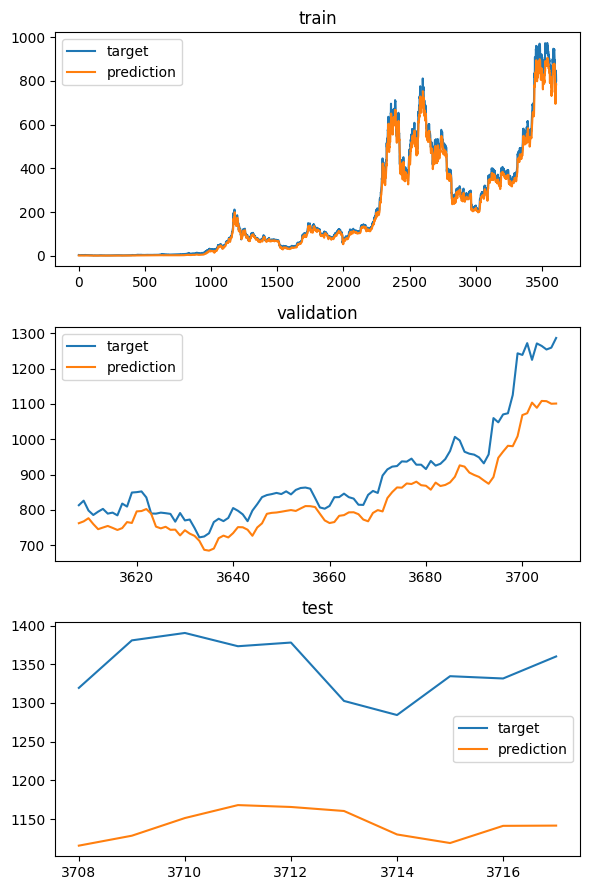

In [140]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

BASE_PATH = os.getcwd()  # 현재 작업 디렉터리를 BASE_PATH로 설정
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

# 테스트 함수
def test(test_model):
    _, _, test_data_loader = get_btc_krw_data()

    test_model.eval()

    y_normalizer = 100

    print("[TEST DATA]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            output_test = test_model(input_test)

        # 예측값과 실제값 출력
        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                idx,
                output.item() * y_normalizer,
                target.item() * y_normalizer,
                abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
            ))

# 전체 데이터셋에 대해 예측 및 시각화
def predict_all(test_model):
    y_normalizer = 100

    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
            sequence_size=10, validation_size=100, test_size=10,
            target_column='Close', y_normalizer=1.0e7, is_regression=True
    )

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    # 데이터셋 및 라벨 설정
    dataset_list = [
        train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
    ]
    dataset_labels = [
        "train", "validation", "test"
    ]
    num = 0
    
    # 시각화
    fig, axs = plt.subplots(3, 1, figsize=(6, 9))

    for i in range(3):
        X = []
        TARGET_Y = []
        PREDICTION_Y = []
        for data in dataset_list[i]:
            input, target = data
            prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

            X.append(num)
            TARGET_Y.append(target.item() * y_normalizer)
            PREDICTION_Y.append(prediction.item() * y_normalizer)

            num += 1

        axs[i].plot(X, TARGET_Y, label='target')
        axs[i].plot(X, PREDICTION_Y, label='prediction')
        axs[i].set_title(dataset_labels[i])
        axs[i].legend()

    plt.tight_layout()
    plt.show()


def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
    }

    project_name = "lstm_regression_btc_krwlstm_regression_btc_krw"
    print(os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"))
    wandb.init(
        mode="disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config
    )

    # 모델 초기화 및 체크포인트 로드
    test_model = get_model()

    project_name = "btc-krw"
    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
    )
    print("MODEL FILE: {0}".format(latest_file_path))
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

    test(test_model)
    predict_all(test_model)


if __name__ == "__main__":
    try:
        # Jupyter 환경이 아닌 경우 argparse 사용
        parser = get_parser()
        args = parser.parse_args()
    except:
        # Jupyter Notebook 환경에서 argparse 대체
        class Args:
            wandb = False
            batch_size = 32
            epochs = 10_000
            learning_rate = 1e-4
            weight_decay = 0.01
            validation_intervals = 10
            early_stop_patience = 10
            early_stop_delta = 1e-5

        args = Args()

    main(args)


## classification

In [141]:
wandb.login(relogin=True)

True

In [143]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = os.getcwd()  # 현재 작업 디렉터리를 BASE_PATH로 설정
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

# 모델 정의
def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output, hidden_size=128, num_layers=2, dropout_rate=0.2):
            super().__init__()
            self.lstm = nn.LSTM(
                input_size=n_input,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout_rate,
            )
            self.dropout = nn.Dropout(p=dropout_rate)
            self.fc1 = nn.Linear(hidden_size, 64)
            self.fc2 = nn.Linear(64, n_output)
            self.relu = nn.ReLU()

        def forward(self, x):
            x, _ = self.lstm(x)  # LSTM 결과
            x = self.dropout(x[:, -1, :])  # Dropout 적용 및 마지막 타임스텝 사용
            x = self.relu(self.fc1(x))  # 첫 번째 Fully Connected Layer
            x = self.fc2(x)  # 두 번째 Fully Connected Layer
            return x

    return MyModel(n_input=5, n_output=2, hidden_size=128, num_layers=2, dropout_rate=0.3)


def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay
    }

    project_name = "classification_lstm"
    
    wandb.finish()
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="Classification with LSTM improvements",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )

    # Config 업데이트
    if 'weight_decay' not in wandb.config:
        wandb.config.update({'weight_decay': args.weight_decay})

    print("Wandb Config:", wandb.config)

    train_data_loader, validation_data_loader, _ = get_btc_krw_data(
        sequence_size=21, validation_size=150, test_size=30, is_regression=False
    )
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model()
    model.to(device)
    wandb.watch(model, log="all", log_freq=100)

    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()


if __name__ == "__main__":
    sys.argv = ['']
    parser = get_parser()
    args = parser.parse_args()

    # 하이퍼파라미터 설정
    args.wandb = True
    args.epochs = 200
    args.batch_size = 64
    args.learning_rate = 1e-3
    args.weight_decay = 1e-5
    args.validation_intervals = 20
    args.early_stop_patience = 10
    args.early_stop_delta = 1e-4

    main(args)


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Wandb Config: {'epochs': 200, 'batch_size': 64, 'validation_intervals': 20, 'learning_rate': 0.001, 'early_stop_patience': 10, 'early_stop_delta': 0.0001, 'weight_decay': 1e-05}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69294, T_accuracy: 52.4242 | V_loss: 0.69292, V_accuracy: 53.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  20] T_loss: 0.69067, T_accuracy: 53.2464 | V_loss: 0.69285, V_accuracy: 52.6667 | Early stopping counter: 1 out of 10 | T_time: 00:00:05, T_speed: 4.000
[Epoch  40] T_loss: 0.69108, T_accuracy: 52.8778 | V_loss: 0.69352, V_accuracy: 45.3333 | Early stopping counter: 2 out of 10 | T_time: 00:00:10, T_speed: 4.000
[Epoch  60] T_loss: 0.69096, T_accuracy: 53.5016 | V_loss: 0.69386, V_accuracy: 46.6667 | Early stopping counter: 3 out of 10 | T_time: 00:00:15, T_speed: 4.000
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch  80] T_loss: 0.69035, T_accuracy: 53.6150 | V_loss: 0.69149

Epoch,▁▂▂▃▄▄▅▆▇▇█
Training accuracy (%),▁▁▁▂▂▂▂▃▅▇█
Training loss,███████▇▆▃▁
Training speed (epochs/sec.),▁██████████
Validation accuracy (%),█▇▂▃▅▅▅▆▂▃▁
Validation loss,▁▁▁▁▁▁▁▁▂▅█
Epoch,200
Training accuracy (%),66.4871
Training loss,0.53386
Training speed (epochs/sec.),3.84615
Validation accuracy (%),44.66667


## classification test

In [145]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb

BASE_PATH = os.getcwd()  # 현재 작업 디렉터리를 BASE_PATH로 설정
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

# 테스트 함수
def test(test_model):
    _, _, test_data_loader = get_btc_krw_data(is_regression=False)

    test_model.eval() # 모델 평가 모드 설정

    num_corrects_test = 0 # 정확히 예측한 샘플 개수
    num_tested_samples = 0 # 테스트된 샘플 총 개수

    print("[TEST DATA]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            output_test = test_model(input_test) # 모델 예측

            predicted_test = torch.argmax(output_test, dim=1) # 가장 높은 확률의 클래스 선택
            num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

            num_tested_samples += len(input_test)

        test_accuracy = 100.0 * num_corrects_test / num_tested_samples

        print(f"TEST RESULTS: {test_accuracy:6.3f}%")

        # 예측값과 실제값 출력
        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
                idx, torch.argmax(output).item(), target.item()
            ))


def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
    }

    project_name = "classification_lstm"
    wandb.init(
        mode="disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )

    # 모델 로드 및 체크포인트 경로 설정
    test_model = get_model()
    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
    )
    print(f"MODEL FILE: {latest_file_path}")
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

    # 기존 학습된 모델을 테스트
    test(test_model)


if __name__ == "__main__":
    try:
        # Jupyter 환경이 아닌 경우 argparse 사용
        parser = get_parser()
        args = parser.parse_args()
    except:
        # Jupyter 환경인 경우 기본값 설정
        class Args:
            wandb = True
            batch_size = 32
            epochs = 10_000  
            learning_rate = 1e-4  
            validation_intervals = 10  
            early_stop_patience = 10 
            early_stop_delta = 0.00001
            weight_decay = 0.01

        args = Args()

    main(args)


MODEL FILE: /home/work/checkpoints/classification_lstm_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 56.667%
 0:   0.00 <-->   0.00
 1:   0.00 <-->   0.00
 2:   1.00 <-->   0.00
 3:   1.00 <-->   0.00
 4:   1.00 <-->   0.00
 5:   1.00 <-->   1.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   0.00
 8:   1.00 <-->   1.00
 9:   0.00 <-->   1.00
10:   1.00 <-->   1.00
11:   1.00 <-->   1.00
12:   1.00 <-->   0.00
13:   1.00 <-->   1.00
14:   1.00 <-->   0.00
15:   1.00 <-->   1.00
16:   0.00 <-->   0.00
17:   1.00 <-->   0.00
18:   1.00 <-->   1.00
19:   1.00 <-->   1.00
20:   1.00 <-->   1.00
21:   0.00 <-->   1.00
22:   1.00 <-->   1.00
23:   0.00 <-->   0.00
24:   0.00 <-->   1.00
25:   1.00 <-->   0.00
26:   1.00 <-->   0.00
27:   1.00 <-->   1.00
28:   0.00 <-->   0.00
29:   0.00 <-->   1.00


# 과제3

## Regression

In [166]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path
import pandas as pd

BASE_PATH = os.getcwd()
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
    # 데이터를 로드
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = get_cryptocurrency_data(
        sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
        target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
    )

    # Next_Open 피처 추가
    def add_next_open_feature(data):
        next_open = data[1:, :, 0]  # Open 컬럼의 다음 값 가져오기
        padded_next_open = torch.cat((next_open, torch.zeros(1, data.size(1))), dim=0)  # 마지막 값은 0으로 패딩
        return torch.cat((data, padded_next_open.unsqueeze(-1)), dim=-1)

    X_train = add_next_open_feature(X_train)
    X_validation = add_next_open_feature(X_validation)
    X_test = add_next_open_feature(X_test)

    print(f"X_train.shape: {X_train.shape}, X_validation.shape: {X_validation.shape}, X_test.shape: {X_test.shape}")

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=False)
    test_data_loader = DataLoader(dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=False)

    return train_data_loader, validation_data_loader, test_data_loader
## regression test
# 모델 정의 (Next_Open 피처에 맞게 입력 크기 수정)
def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
            self.dropout = nn.Dropout(p=0.3)  # 과적합 방지
            self.fc1 = nn.Linear(in_features=256, out_features=64)
            self.fc2 = nn.Linear(in_features=64, out_features=n_output)

        def forward(self, x):
            x, _ = self.lstm(x)
            x = x[:, -1, :]  # 마지막 타임스텝
            x = self.dropout(x)
            x = torch.relu(self.fc1(x))
            x = self.fc2(x)
            return x

    return MyModel(n_input=6, n_output=1)  # n_input=6으로 변경

def main():
    # 기본 설정 값
    class Args:
        wandb = True
        batch_size = 32
        epochs = 200  # 에포크 수 증가
        learning_rate = 1e-3  # 학습률 증가
        validation_intervals = 5
        early_stop_patience = 15
        early_stop_delta = 0.0001
        weight_decay = 1e-5  # 더 작은 weight decay

    args = Args()

    # Config 설정
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay,
    }
    
    if 'weight_decay' not in wandb.config:
        print("Setting default weight_decay in wandb.config.")
        wandb.config.update({'weight_decay': args.weight_decay})

    wandb.finish()
    
    wandb.init(
        mode="online",
        project="regression3",
        notes="Experiment with BiLSTM and dropout",
        tags=["BiLSTM", "regression", "btc_krw"],
        config=config,
    )

    train_data_loader, validation_data_loader, _ = get_btc_krw_data()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model()
    model.to(device)

    optimizer = optim.Adam(
        model.parameters(),
        lr=wandb.config.learning_rate,
        weight_decay=wandb.config.weight_decay
    )

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)  # 학습률 감소

    regression_trainer = RegressionTrainer(
        "btc-krw", model, optimizer, train_data_loader, validation_data_loader, None,
        wandb.run.name, wandb, device, CHECKPOINT_FILE_PATH
    )
    regression_trainer.train_loop()

    wandb.finish()

if __name__ == "__main__":
    main()

Setting default weight_decay in wandb.config.


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


X_train.shape: torch.Size([3527, 21, 6]), X_validation.shape: torch.Size([150, 21, 6]), X_test.shape: torch.Size([30, 21, 6])
Training on device cuda:0.
[Epoch   1] T_loss: 1.03779, V_loss: 0.12323, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.002
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch   5] T_loss: 0.03450, V_loss: 0.08945, V_loss decreased (0.12323 --> 0.08945). Saving model... | T_time: 00:00:03, T_speed: 0.049
[Epoch  10] T_loss: 0.03018, V_loss: 0.20223, Early stopping counter: 1 out of 15 | T_time: 00:00:06, T_speed: 0.041
[Epoch  15] T_loss: 0.02851, V_loss: 0.20398, Early stopping counter: 2 out of 15 | T_time: 00:00:09, T_speed: 0.040
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch  20] T_loss: 0.02343, V_loss: 0.07803, V_loss decreased (0.08945 --> 0.07803). Saving model... | T_time: 00:00:12, T_speed: 0.040
Model checkpoint saved at: /home/work/chec

Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▅▂▁▁▁▁▁▁▅▂▂▂▁▁▁▁▅▃▂▂▂▂▁▁█▃▂▂
Validation loss,▅▄██▄▂▃▃▁▃▂▁▅▃▁▂▂█▃▂▁▂▁▄▁▁▂▂▁▄▇▂▁▁▁▁
Epoch,175
Training loss,0.00897
Training speed (epochs/sec.),0.41651
Validation loss,0.01289


## regression test

/home/work/checkpoints/btc-krw_checkpoint_latest.pt
MODEL FILE: /home/work/checkpoints/btc-krw_checkpoint_latest.pt
X_train.shape: torch.Size([3527, 21, 6]), X_validation.shape: torch.Size([150, 21, 6]), X_test.shape: torch.Size([30, 21, 6])
[TEST DATA]
 0: 963.78 <--> 964.63 (Loss:          0.85)
 1: 959.55 <--> 959.09 (Loss:          0.46)
 2: 959.58 <--> 956.43 (Loss:          3.16)
 3: 948.29 <--> 948.70 (Loss:          0.41)
 4: 935.04 <--> 931.83 (Loss:          3.21)
 5: 954.99 <--> 957.10 (Loss:          2.11)
 6: 1,036.23 <--> 1,059.85 (Loss:         23.62)
 7: 1,036.61 <--> 1,047.88 (Loss:         11.27)
 8: 1,050.99 <--> 1,070.26 (Loss:         19.27)
 9: 1,057.38 <--> 1,073.52 (Loss:         16.14)
10: 1,089.77 <--> 1,125.35 (Loss:         35.58)
11: 1,168.16 <--> 1,243.20 (Loss:         75.03)
12: 1,176.02 <--> 1,238.69 (Loss:         62.68)
13: 1,188.46 <--> 1,272.01 (Loss:         83.55)
14: 1,170.74 <--> 1,224.73 (Loss:         53.98)
15: 1,195.82 <--> 1,271.21 (Loss:  

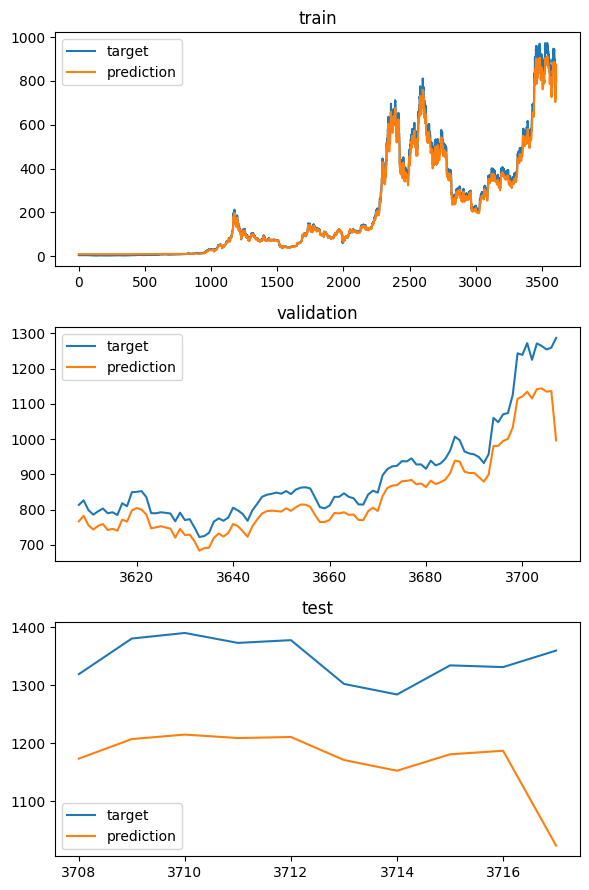

In [168]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

BASE_PATH = os.getcwd()  # 현재 작업 디렉터리를 BASE_PATH로 설정
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

# 테스트 함수
def test(test_model):
    _, _, test_data_loader = get_btc_krw_data()

    test_model.eval()

    y_normalizer = 100

    print("[TEST DATA]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch

            output_test = test_model(input_test)

        # 예측값과 실제값 출력
        for idx, (output, target) in enumerate(zip(output_test, target_test)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                idx,
                output.item() * y_normalizer,
                target.item() * y_normalizer,
                abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
            ))

# 전체 데이터셋에 대해 예측 및 시각화
def predict_all(test_model):
    y_normalizer = 100

    # 데이터를 로드
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
            sequence_size=10, validation_size=100, test_size=10,
            target_column='Close', y_normalizer=1.0e7, is_regression=True
    )

    # Next_Open 피처 추가 함수
    def add_next_open_feature(data):
        next_open = data[1:, :, 0]  # Open 컬럼의 다음 값 가져오기
        padded_next_open = torch.cat((next_open, torch.zeros(1, data.size(1))), dim=0)  # 마지막 값은 0으로 패딩
        return torch.cat((data, padded_next_open.unsqueeze(-1)), dim=-1)

    # Next_Open 피처 추가
    X_train = add_next_open_feature(X_train)
    X_validation = add_next_open_feature(X_validation)
    X_test = add_next_open_feature(X_test)

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    # 데이터셋 및 라벨 설정
    dataset_list = [
        train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
    ]
    dataset_labels = [
        "train", "validation", "test"
    ]
    num = 0

    # 시각화
    fig, axs = plt.subplots(3, 1, figsize=(6, 9))

    for i in range(3):
        X = []
        TARGET_Y = []
        PREDICTION_Y = []
        for data in dataset_list[i]:
            input, target = data
            prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

            X.append(num)
            TARGET_Y.append(target.item() * y_normalizer)
            PREDICTION_Y.append(prediction.item() * y_normalizer)

            num += 1

        axs[i].plot(X, TARGET_Y, label='target')
        axs[i].plot(X, PREDICTION_Y, label='prediction')
        axs[i].set_title(dataset_labels[i])
        axs[i].legend()

    plt.tight_layout()
    plt.show()


def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
    }

    project_name = "btc-krw"
    print(os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"))
    wandb.init(
        mode="disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw"],
        name=run_time_str,
        config=config
    )

    # 모델 초기화 및 체크포인트 로드
    test_model = get_model()

    project_name = "btc-krw"
    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
    )
    print("MODEL FILE: {0}".format(latest_file_path))
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

    test(test_model)
    predict_all(test_model)


if __name__ == "__main__":
    try:
        # Jupyter 환경이 아닌 경우 argparse 사용
        parser = get_parser()
        args = parser.parse_args()
    except:
        # Jupyter Notebook 환경에서 argparse 대체
        class Args:
            wandb = False
            batch_size = 32
            epochs = 10_000
            learning_rate = 1e-4
            weight_decay = 0.01
            validation_intervals = 10
            early_stop_patience = 10
            early_stop_delta = 1e-5

        args = Args()

    main(args)## regression test


## classification

In [189]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path
import pandas as pd

BASE_PATH = os.getcwd()
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

# 데이터 로드 함수 (Next_Open 피처 추가)
def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
    # 데이터를 로드
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date = get_cryptocurrency_data(
        sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
        target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
    )

    # Next_Open 피처 추가
    def add_next_open_feature(data):
        next_open = data[:, :, 0][1:]  # Open 컬럼의 다음 값 가져오기
        padded_next_open = torch.cat((next_open, torch.zeros(1, data.size(1))), dim=0)  # 마지막 값은 0으로 패딩
        return torch.cat((data, padded_next_open.unsqueeze(-1)), dim=-1)

    X_train = add_next_open_feature(X_train)
    X_validation = add_next_open_feature(X_validation)
    X_test = add_next_open_feature(X_test)

    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

    train_data_loader = DataLoader(dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=False)
    test_data_loader = DataLoader(dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=False)

    return train_data_loader, validation_data_loader, test_data_loader

# 모델 정의 (Next_Open 피처에 맞게 입력 크기 수정)
def get_model():
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
            self.dropout = nn.Dropout(p=0.3)  # 과적합 방지
            self.fc1 = nn.Linear(in_features=256, out_features=64)
            self.fc2 = nn.Linear(in_features=64, out_features=n_output)

        def forward(self, x):
            x, _ = self.lstm(x)
            x = x[:, -1, :]  # 마지막 타임스텝
            x = self.dropout(x)
            x = torch.relu(self.fc1(x))
            x = self.fc2(x)
            return x

    return MyModel(n_input=6, n_output=1)  # n_input=6으로 변경

def main():
    # 기본 설정 값
    class Args:
        wandb = True
        batch_size = 32
        epochs = 200  # 에포크 수 증가
        learning_rate = 1e-3  # 학습률 증가
        validation_intervals = 5
        early_stop_patience = 15
        early_stop_delta = 0.0001
        weight_decay = 1e-5  # 더 작은 weight decay

    args = Args()

    # Config 설정
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay,
    }
    
    if 'weight_decay' not in wandb.config:
        print("Setting default weight_decay in wandb.config.")
        wandb.config.update({'weight_decay': args.weight_decay})

    wandb.finish()
    
    wandb.init(
        mode="online",
        project="classification3",
        notes="Experiment with BiLSTM and dropout",
        tags=["BiLSTM", "regression", "btc_krw"],
        config=config,
    )

    train_data_loader, validation_data_loader, _ = get_btc_krw_data()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model()
    model.to(device)

    optimizer = optim.Adam(
        model.parameters(),
        lr=wandb.config.learning_rate,
        weight_decay=wandb.config.weight_decay
    )

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)  # 학습률 감소

    regression_trainer = RegressionTrainer(
        "btc-krw", model, optimizer, train_data_loader, validation_data_loader, None,
        wandb.run.name, wandb, device, CHECKPOINT_FILE_PATH
    )
    regression_trainer.train_loop()

    wandb.finish()

if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Training on device cuda:0.
[Epoch   1] T_loss: 1.21600, V_loss: 0.22971, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.002
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch   5] T_loss: 0.03296, V_loss: 0.13146, V_loss decreased (0.22971 --> 0.13146). Saving model... | T_time: 00:00:03, T_speed: 0.033
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch  10] T_loss: 0.02675, V_loss: 0.12382, V_loss decreased (0.13146 --> 0.12382). Saving model... | T_time: 00:00:06, T_speed: 0.034
Model checkpoint saved at: /home/work/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[Epoch  15] T_loss: 0.02572, V_loss: 0.06095, V_loss decreased (0.12382 --> 0.06095). Saving model... | T_time: 00:00:09, T_speed: 0.034
[Epoch  20] T_loss: 0.02096, V_loss: 0.11049, Early stopping counter: 1 out of 15 | T_time: 00:00:12, T_speed: 0.034
Model checkpoint saved at: /home/work/checkpoints/lst

Epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▂▁▁▁▁▁▁█▁▁▁▁▁▁▁▇
Validation loss,█▅▅▃▄▂▁▄▂▅▃▂▁▃▂▁▄▃▁▂▂▃▁▃▁▃▁▃▄▁▁
Epoch,150
Training loss,0.00702
Training speed (epochs/sec.),10.45223
Validation loss,0.01574


## classification test

In [191]:
import torch
import os
from datetime import datetime
import wandb

BASE_PATH = os.getcwd()  # Set the current working directory as BASE_PATH
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
    os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

# Test function
def test(test_model):
    # 테스트 데이터 로드
    _, _, test_data_loader = get_btc_krw_data(is_regression=False)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_model.to(device)
    test_model.eval()  # 모델 평가 모드 설정

    num_corrects_test = 0  # 정확히 예측한 샘플 개수
    num_tested_samples = 0  # 테스트된 샘플 총 개수

    print("[TEST DATA]")
    with torch.no_grad():
        for test_batch in test_data_loader:
            input_test, target_test = test_batch
            input_test, target_test = input_test.to(device), target_test.to(device)

            if input_test.size(-1) == 5: 
                next_open = input_test[:, :, 0].roll(shifts=-1, dims=1) 
                next_open[:, -1] = 0 ## regression test
                input_test = torch.cat((input_test, next_open.unsqueeze(-1)), dim=-1)

            output_test = test_model(input_test)  # 모델 예측
            predicted_test = torch.argmax(output_test, dim=1)  # 가장 높은 확률의 클래스 선택
            num_corrects_test += (predicted_test == target_test).sum().item()

            num_tested_samples += len(input_test)

        test_accuracy = 100.0 * num_corrects_test / num_tested_samples
        print(f"TEST RESULTS: {test_accuracy:6.3f}%")

# Main function
def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
    }

    project_name = "classification_lstm"
    wandb.init(
        mode="disabled",
        project=project_name,
        notes="Testing classification LSTM",
        config=config
    )

    # Load model
    test_model = get_model()
    latest_file_path = os.path.join(
        CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
    )
    print(f"MODEL FILE: {latest_file_path}")

    # Load common keys from the checkpoint
    checkpoint = torch.load(latest_file_path, map_location="cpu")
    model_dict = test_model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict and model_dict[k].shape == v.shape}
    model_dict.update(pretrained_dict)
    test_model.load_state_dict(model_dict)

    # Run the test
    test(test_model)

if __name__ == "__main__":
    try:
        # Use argparse in non-Jupyter environments
        parser = get_parser()
        args = parser.parse_args()
    except:
        # Set defaults in Jupyter environments
        class Args:
            wandb = True
            batch_size = 32
            epochs = 10_000  
            learning_rate = 1e-4  
            validation_intervals = 10  
            early_stop_patience = 10 
            early_stop_delta = 0.00001
            weight_decay = 0.01

        args = Args()

    main(args)


MODEL FILE: /home/work/checkpoints/classification_lstm_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 46.667%


#  기술적으로 얻은 점

LSTM 및 BiLSTM 활용 이해
LSTM과 BiLSTM을 사용하여 시계열 데이터의 시간 의존성을 학습하는 방법과, BiLSTM을 통해 데이터의 과거와 미래 정보를 효과적으로 활용할 수 있음을 경험했습니다.

데이터 전처리 및 피처 엔지니어링
Next_Open 특성과 같은 추가 데이터를 생성하여 모델 입력을 강화했고, 데이터셋 분리 및 DataLoader를 사용해 효율적인 데이터 처리를 수행했습니다.

학습 및 테스트 파이프라인 구축
조기 중지(early stopping)와 검증 루프를 활용한 학습 최적화와, 테스트 파이프라인 설계로 모델 성능 평가와 결과 출력을 체계화했습니다.

하이퍼파라미터 튜닝
학습률, 배치 크기, 가중치 감소 등 하이퍼파라미터가 모델 성능에 미치는 영향을 확인하고, 적절히 튜닝하는 방법을 익혔습니다.

모델 체크포인트 및 재사용
학습된 모델을 저장하고 재사용하는 과정을 통해, 모델 구조 변경 시 호환성 문제를 해결하고 테스트 환경에서 효율적으로 적용하는 방법을 배웠습니다.

손실 함수와 성능 지표의 선택
분류 작업에는 CrossEntropyLoss, 회귀 작업에는 MSELoss를 사용하는 등 작업에 맞는 손실 함수를 선택하는 중요성을 학습했습니다.

디버깅 및 문제 해결
입력 데이터 크기 불일치, 체크포인트 로드 문제 등 다양한 오류를 해결하며 디버깅 능력을 향상시켰습니다.

실험 관리 및 시각화
Weights & Biases(WandB)를 사용해 실험 결과를 관리하고 하이퍼파라미터와 모델 성능을 시각화하며 분석 능력을 강화했습니다.

# 숙제 후기

이번 과제를 통해 단순한 모델 설계와 학습을 넘어 데이터 처리, 하이퍼파라미터 튜닝, 모델 성능 평가까지 다양한 과정에서 중요한 통찰을 얻을 수 있었습니다. 특히 LSTM과 BiLSTM을 활용해 시계열 데이터를 분석하는 과정을 경험하면서, 시간 의존성을 고려한 모델링의 복잡함과 재미를 느꼈습니다.

과제를 진행하며 가장 어려웠던 점은 디버깅 과정이었습니다. 학습 데이터와 테스트 데이터의 특성 불일치, 체크포인트 로드 중 발생한 문제 등 예상치 못한 오류가 여러 차례 발생했지만, 이를 해결하는 과정에서 디버깅 능력을 키우고 문제 해결의 중요성을 깨닫게 되었습니다.

또한, 모델 성능이 기대에 미치지 못했을 때 원인을 분석하고 개선점을 찾는 과정에서 실험의 반복과 분석이 얼마나 중요한지 배울 수 있었습니다. 특히 하이퍼파라미터 조정과 데이터 전처리의 작은 변화가 모델 성능에 큰 영향을 미친다는 점을 실감하며, 실험의 세밀함과 체계적인 관리의 필요성을 느꼈습니다.

마지막으로, 이번 과제를 통해 Weights & Biases(WandB)와 같은 도구의 중요성을 알게 되었습니다. 실험 과정을 체계적으로 기록하고 시각화하며 결과를 비교할 수 있어, 실험 관리를 더 효율적으로 할 수 있었습니다.

이번 과제는 단순히 코드를 작성하는 것을 넘어, 모델 설계와 실험, 분석 과정의 모든 단계를 경험할 수 있는 유익한 시간이었으며, 앞으로 더 복잡한 프로젝트에서도 이 경험을 바탕으로 자신감을 가지고 임할 수 있을 것 같습니다.